In [131]:
# Importing Important libraries
import jax
# import numpy as np              # For Scientific Computation
import matplotlib.pyplot as plt # Visualization Library
import jax.numpy as jnp         # For importing jax]
from jax import grad, vmap, jit # For importing Transformation functions
from jax import random
import matplotlib

In [14]:
# Fetching of data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [15]:
# Retrieving features and labels
X = mnist['data']
Y = mnist['target']

In [16]:
# Converting into NumPy array with integer datatype
X = jnp.array(X , dtype = 'int32')
Y = jnp.array(Y , dtype = 'int32')

In [17]:
# #loading data on gpu
if jax.devices("gpu"):
    gpu_device = jax.devices("gpu")[0]
    X = jax.device_put(X, device = gpu_device)
    Y = jax.device_put(Y, device = gpu_device)
else:
    print("No GPU devices found.")

In [18]:
# Reshaping
Y = Y.reshape(1,70000)
X = X.reshape(70000,-1).T
print(X.shape)

(784, 70000)


In [19]:
# Verifying the shape of image
Lets_plot = X[:,60000]
Lets_plot_image = Lets_plot.reshape(28,28)
print(Lets_plot_image.shape)

(28, 28)


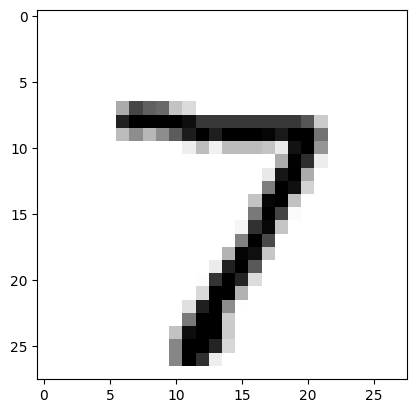

In [20]:
# Plotting any one image to verify the correct fetching of data
plt.imshow(Lets_plot_image, cmap = matplotlib.cm.binary, interpolation = "nearest")

In [21]:
# Label Corresponding to above image
Y[:,60000]

Array([7], dtype=int32)

In [22]:
# Pre-Processing of the data
X_train = X[:,:60000]
X_test  = X[:,60000:]
Y_train = Y[:,:60000]
Y_test  = Y[:,60000:]
X_train = X_train
X_test = X_test
X_train = X_train / 255
X_test = X_test / 255
Y_train.size

60000

In [222]:
# Initialization
def initialize_parameters():
  seed = 0
  key = random.PRNGKey(seed)
  W1 = random.normal(key,(196,784)) * 0.01
  W2 = random.normal(key,(98,196))  * 0.01
  W3 = random.normal(key,(49,98))   * 0.01
  W4 = random.normal(key,(10,49))   * 0.01
  b1 = jnp.zeros((196,1))
  b2 = jnp.zeros((98,1))
  b3 = jnp.zeros((49,1))
  b4 = jnp.zeros((10,1))
  parameters = { "W1": W1, "W2": W2, "W3": W3, "W4": W4, "b1": b1, "b2": b2, "b3": b3, "b4": b4 }
  return parameters
  # Activations
def ReLU(Z):
  return jnp.maximum(Z, 0)

def SoftMax(Z):
  A = jnp.exp(Z) / jnp.sum(jnp.exp(Z), axis = 0, keepdims = True)
  return A

In [223]:
# Forward Propagation
def forward_propagation(params, X):
  W1 = params["W1"]
  W2 = params["W2"]
  W3 = params["W3"]
  W4 = params["W4"]
  b1 = params["b1"]
  b2 = params["b2"]
  b3 = params["b3"]
  b4 = params["b4"]
  Z1 = jnp.dot(W1,X) + b1
  A1 = ReLU(Z1)
  Z2 = jnp.dot(W2,A1) + b2
  A2 = ReLU(Z2)
  Z3 = jnp.dot(W3,A2) + b3
  A3 = ReLU(Z3)
  Z4 = jnp.dot(W4,A3) + b4
  A4 = SoftMax(Z4)
  return A4

In [224]:
def compute_cost(params, X, Y):
  m = Y.size
  A4 = forward_propagation(params, X)
  cost = -1/m * jnp.sum(Y*jnp.log(A4))
  return cost

In [225]:
def one_hot(Y):
  encoded_array = jnp.zeros((Y.size, Y.max() + 1), dtype = "int32")
  # Jax object does not support item assignment. JAX arrays are immutable. Therefore, we use set method
  encoded_array = encoded_array.at[jnp.arange(Y.size), Y].set(1)
  encoded_array = jnp.transpose(encoded_array)
  return encoded_array

In [226]:
def update_parameters(params, X, Y, learning_rate):
  grads = grad(compute_cost)(params, X, one_hot(Y))
  return jax.tree_map(
      lambda p, g: p - learning_rate*g, params, grads
  )

In [227]:

def get_predictions(A2):
  return jnp.argmax(A2, 0)

def get_accuracy(predictions, Y):
  print(predictions, Y)
  return jnp.sum(predictions == Y)/ Y.size

def Gradient_Descent(X, Y, No_Of_Iterations, Learning_Rate):
  parameters = initialize_parameters()
  costs = []
  accuracy = []
  for i in range(0, No_Of_Iterations):
    A4 = forward_propagation(parameters, X)
    cost = compute_cost(parameters, X, one_hot(Y))
    parameters = update_parameters(parameters, X, Y, Learning_Rate)
    if i% 100 == 0:
      print("Cost after iteration {}: {}".format(i, jnp.squeeze(cost)))
    if i % 100 == 0 or i == No_Of_Iterations:
      print("Iterations: " + str(i))
      costs.append(cost)
      predictions = get_predictions(A4)
      acy = get_accuracy(predictions, Y) * 100
      accuracy.append(acy)
      print("Accuracy  :" + str(get_accuracy(predictions, Y) * 100) + str("%"))
  return parameters, costs, accuracy

In [250]:
parameters, costs, accuracy = Gradient_Descent(X_train, Y_train, 7000, 0.5)

Cost after iteration 0: 0.2302585393190384
Iterations: 0
[4 2 2 ... 5 2 5] [[5 0 4 ... 5 6 8]]
[4 2 2 ... 5 2 5] [[5 0 4 ... 5 6 8]]
Accuracy  :8.113334%
Cost after iteration 100: 0.2301664799451828
Iterations: 100
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :11.236667%
Cost after iteration 200: 0.2301332801580429
Iterations: 200
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :11.236667%
Cost after iteration 300: 0.23012122511863708
Iterations: 300
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :11.236667%
Cost after iteration 400: 0.23011673986911774
Iterations: 400
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :11.236667%
Cost after iteration 500: 0.23011496663093567
Iterations: 500
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :11.236667%
Cost after iteration 600: 0.2301141619682312
Ite

In [251]:
A4 = forward_propagation(parameters, X_test)
predictions = get_predictions(A4)
print("Accuracy  :" + str(get_accuracy(predictions, Y_test)))

[7 2 1 ... 4 5 6] [[7 2 1 ... 4 5 6]]
Accuracy  :0.94150007


In [252]:
def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

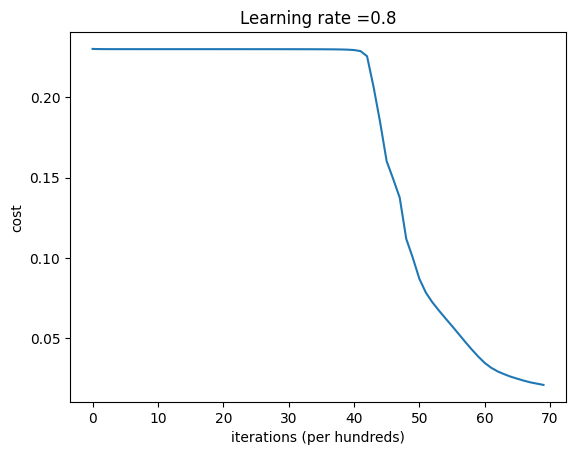

In [253]:
plot_costs(costs, 0.8)

In [254]:
def plot_accuracy(accuracy, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('Accuracy')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

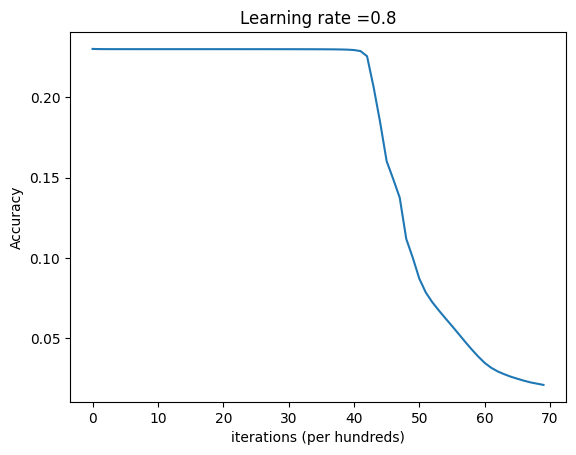

In [255]:
plot_accuracy(accuracy, 0.8)